# Dependencies

In [2]:
# built-in dependencies
import os
import pickle
import time

# 3rd party dependencies
import psycopg2
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from deepface import DeepFace

# Load Facial Dataset

DeepFace's unit test items are available at https://github.com/serengil/deepface/tree/master/tests/dataset

In [3]:
pivot_file = 'facialdb.pkl'

if os.path.exists(pivot_file) is False:
    instances = []
    for dirpath, dirnames, filenames in os.walk("deepface/tests/dataset/"):
        for filename in filenames:
            img_path = f"{dirpath}{filename}"
            if not img_path.endswith(".jpg"):
                continue

            objs = DeepFace.represent(
                img_path=img_path,
                model_name="Facenet"
            )

            embedding = objs[0]["embedding"]
            instances.append((img_path, embedding))

    with open(pivot_file, 'wb') as file:
        pickle.dump(instances, file)
else:
    with open(pivot_file, 'rb') as file:
        instances = pickle.load(file)

In [4]:
# there are a few instances! let's create synthetic data to see the limit.
len(instances)

63

In [5]:
target_size = 100000

for i in range(len(instances), target_size):
    img_name = f"synthetic_{i}.jpg"
    # generate 128-d embedding with dimension values in [-5, +5]
    embedding = np.random.uniform(-5, 5, 128).tolist()
    instances.append((img_name, embedding))

In [6]:
# now, we have good size of dataset.
len(instances)

100000

# Store to db

In [7]:
conn = psycopg2.connect(
    host="localhost",
    port="5432",
    database="postgres",
    user=user,
    password=password,
)

cursor = conn.cursor()

In [9]:
# prefer to run these statements from postgres' power shell,
# but they can be run here as well

cursor.execute("create extension if not exists vector;")
print("vector extension refreshed")

cursor.execute("drop table if exists identities;")
print("identities table dropped")

cursor.execute("""
    create table identities (
    ID INT primary key,
    IMG_NAME VARCHAR(100),
    embedding vector(128));
""")
print("identities table created")

vector extension refreshed
identities table dropped
identities table created


In [10]:
for idx, (img_path, embedding) in tqdm(enumerate(instances)):
    statement = f"""
        insert into 
        identities 
        (id, img_name, embedding) 
        values 
        ({idx}, '{img_path}', '{str(embedding)}');
    """
    cursor.execute(statement)

100000it [00:17, 5687.46it/s]


In [11]:
# commit once all inserts done
conn.commit()

# Create Index

Otherwise, pgvector will perform exact nearest neighbor.

In [12]:
tic = time.time()
cursor.execute(
    "CREATE INDEX ON identities USING hnsw (embedding vector_l2_ops);"
)
toc = time.time()

print(f"index created in {round(toc-tic, 2)} seconds")

index created in 58.42 seconds


# Search an identity

That image is not available in unit test items, still we are looking for its identity.

In [14]:
target_path = "target.jpg"

In [15]:
target_img = cv2.imread(target_path)

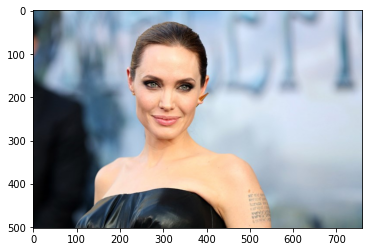

In [16]:
plt.imshow(target_img[:, :, ::-1])
plt.show()

In [17]:
objs = DeepFace.represent(
    img_path=target_path,
    model_name="Facenet"
)

target_embedding = objs[0]["embedding"]

In [13]:
# pre-tuned threshold to classify same person for facenet - euclidean pair
# github.com/serengil/deepface/blob/master/deepface/modules/verification.py#L376
threshold = 10

In [18]:
tic = time.time()
cursor.execute(
    f"""
        SELECT *
        FROM (
            SELECT i.*, embedding <-> '{str(target_embedding)}' as distance
            FROM identities i
        ) a
        WHERE distance < {threshold}
        ORDER BY distance asc
        LIMIT 100
    """
)
results = cursor.fetchall()
toc = time.time()
print(f"search is done in {round(toc-tic, 4)} seconds.")

search is done in 0.0168 seconds.


distance between target.jpg and deepface/tests/dataset/img6.jpg is 6.18


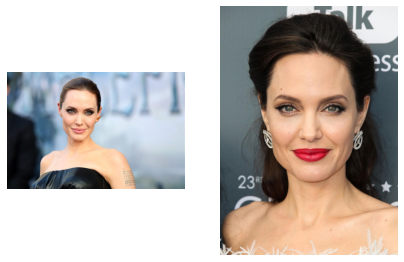

-----------------
distance between target.jpg and deepface/tests/dataset/img10.jpg is 6.21


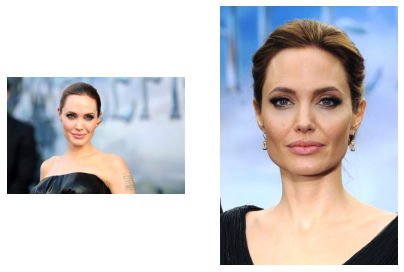

-----------------
distance between target.jpg and deepface/tests/dataset/img5.jpg is 6.38


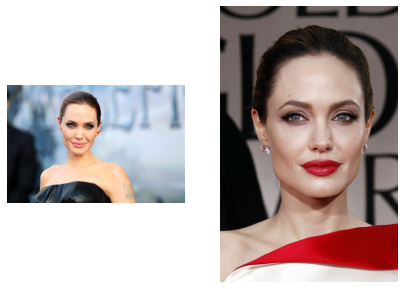

-----------------
distance between target.jpg and deepface/tests/dataset/img7.jpg is 6.4


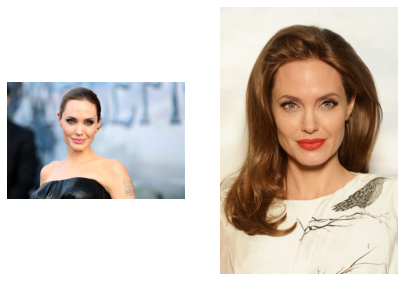

-----------------
distance between target.jpg and deepface/tests/dataset/img1.jpg is 6.65


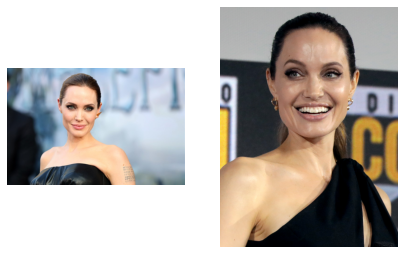

-----------------
distance between target.jpg and deepface/tests/dataset/img2.jpg is 6.8


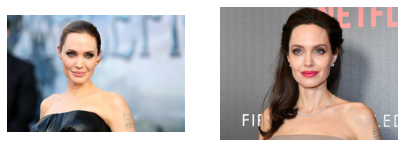

-----------------
distance between target.jpg and deepface/tests/dataset/img11.jpg is 7.76


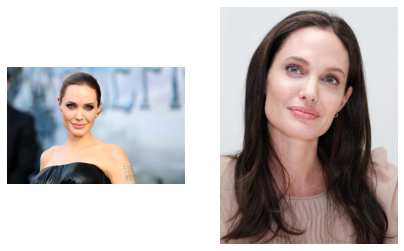

-----------------
distance between target.jpg and deepface/tests/dataset/img4.jpg is 7.77


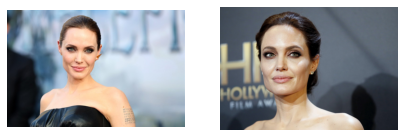

-----------------
distance between target.jpg and deepface/tests/dataset/img11_reflection.jpg is 8.24


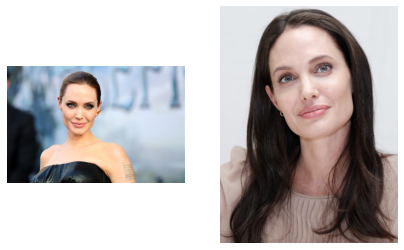

-----------------


In [19]:
for idx, img_name, embedding, distance in results:
    print(f"distance between {target_path} and {img_name} is {round(distance, 2)}")
    
    source_img = cv2.imread(img_name)
    
    fig = plt.figure(figsize=(7, 7))
    
    fig.add_subplot(1, 2, 1)
    plt.imshow(target_img[:,:,::-1])
    plt.axis("off")
    
    fig.add_subplot(1, 2, 2)
    plt.imshow(source_img[:,:,::-1])
    plt.axis("off")
    plt.show()
    print("-----------------")